## üìë √çndice

1. **Introducci√≥n**
2. **Importaci√≥n de Librer√≠as**
3. **Carga Inicial de los Datos**
4. **An√°lisis Exploratorio de Datos**
5. **Preparaci√≥n de los Datos para Prophet**
6. **Modelado con Prophet y Evaluaci√≥n del Modelo**
7. **Conclusiones y Recomendaciones**
8. **Anexos**

## 1. Introducci√≥n 

En este proyecto abordamos el problema de predicci√≥n de demanda en tiendas utilizando modelos de series temporales. Espec√≠ficamente, aplicamos el modelo **Prophet** desarrollado por Facebook, que permite capturar tendencias, estacionalidades (diarias, semanales, anuales) y efectos de d√≠as festivos, siendo una herramienta ideal para datos de retail.  
Nuestro objetivo principal es prever la demanda futura por tienda y productos, lo que puede ayudar a tomar decisiones informadas en log√≠stica, inventario y campa√±as de marketing.

A lo largo del an√°lisis, responderemos preguntas como:

- ¬øCu√°l es el comportamiento estacional de las ventas?
- ¬øQu√© tendencias existen a lo largo del tiempo?
- ¬øC√≥mo se puede anticipar la demanda futura a partir del historial disponible?

## 2. Importaci√≥n de Librer√≠as

In [1]:
# Manipulaci√≥n de datos
import pandas as pd
import numpy as np

In [2]:
# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Modelado
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [4]:
# Validaci√≥n y m√©tricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# Dise√±o
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

## 3. Carga Inicial de los Datos

In [6]:
# Carga de archivos CSV
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [7]:
# Convertir la columna 'date' a tipo datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## 4. An√°lisis Exploratorio de Datos

In [8]:
# Vista general de los datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (913000, 4)
Test shape: (45000, 4)


In [9]:
# Primeras filas
train.head()

date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [10]:
test.head()

id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1

In [11]:
# Ordenamos por fecha
train = train.sort_values('date')
train

date  store  item  sales
0      2013-01-01      1     1     13
211816 2013-01-01      7    12     26
832656 2013-01-01      7    46     27
213642 2013-01-01      8    12     54
215468 2013-01-01      9    12     35
...           ...    ...   ...    ...
619013 2017-12-31      9    34     21
620839 2017-12-31     10    34     32
622665 2017-12-31      1    35     55
598927 2017-12-31      8    33    100
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [12]:
# Buscamos filas duplicados
print("Filas duplicadas:", train.duplicated().sum())

Filas duplicadas: 0


In [13]:
# Buscamos valores nulos
print("Valores nulos:")
train.isna().sum()

Valores nulos:


date     0
store    0
item     0
sales    0
dtype: int64

In [14]:
print("Informaci√≥n de train:")
train.info()

Informaci√≥n de train:
<class 'pandas.core.frame.DataFrame'>
Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.8 MB


In [15]:
print("\nDescripci√≥n estad√≠stica:")
train.describe()


Descripci√≥n estad√≠stica:


date          store           item  \
count                         913000  913000.000000  913000.000000   
mean   2015-07-02 12:00:00.000000256       5.500000      25.500000   
min              2013-01-01 00:00:00       1.000000       1.000000   
25%              2014-04-02 00:00:00       3.000000      13.000000   
50%              2015-07-02 12:00:00       5.500000      25.500000   
75%              2016-10-01 00:00:00       8.000000      38.000000   
max              2017-12-31 00:00:00      10.000000      50.000000   
std                              NaN       2.872283      14.430878   

               sales  
count  913000.000000  
mean       52.250287  
min         0.000000  
25%        30.000000  
50%        47.000000  
75%        70.000000  
max       231.000000  
std        28.801144

In [16]:
print("\nFecha m√≠nima:", train['date'].min())
print("Fecha m√°xima:", train['date'].max())


Fecha m√≠nima: 2013-01-01 00:00:00
Fecha m√°xima: 2017-12-31 00:00:00


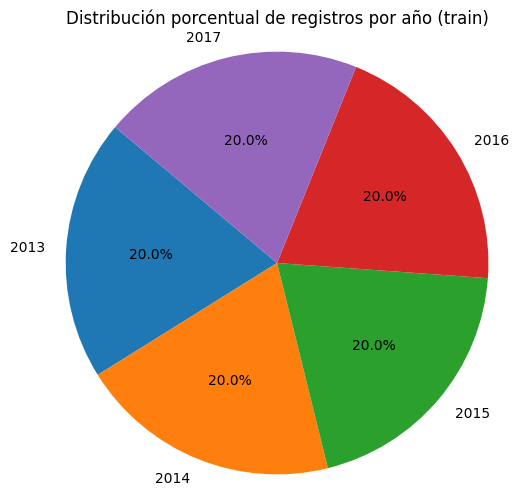

In [17]:
# Porcentaje de registros por a√±o
train['year'] = train['date'].dt.year
year_distribution = train['year'].value_counts(normalize=True).sort_index() * 100

# Gr√°fico circular
plt.figure(figsize=(6, 6))
plt.pie(year_distribution, labels=year_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuci√≥n porcentual de registros por a√±o (train)')
plt.axis('equal')
plt.show()


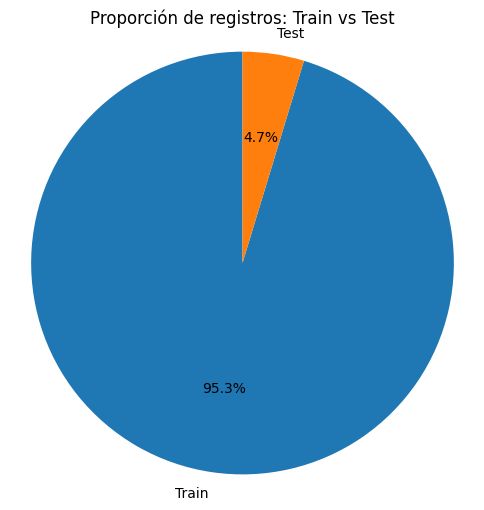

In [18]:
train_size = len(train)
test_size = len(test)
total_size = train_size + test_size

sizes = [train_size, test_size]
labels = ['Train', 'Test']
percentages = [s / total_size * 100 for s in sizes]

# Gr√°fico circular
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proporci√≥n de registros: Train vs Test')
plt.axis('equal')
plt.show()


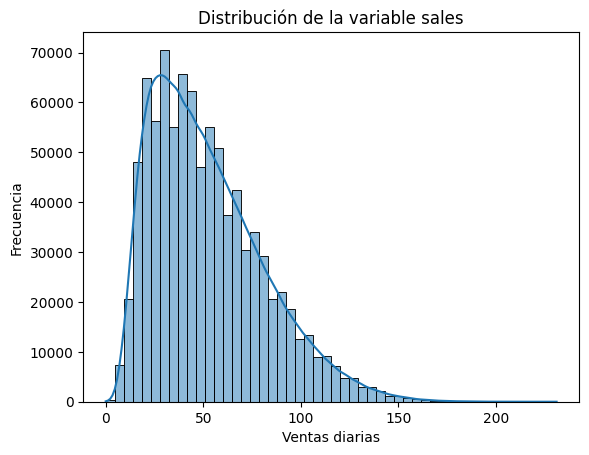

In [19]:
# Distribuci√≥n de ventas
plt.figure()
sns.histplot(train['sales'], bins=50, kde=True)
plt.title('Distribuci√≥n de la variable sales')
plt.xlabel('Ventas diarias')
plt.ylabel('Frecuencia')
plt.show()

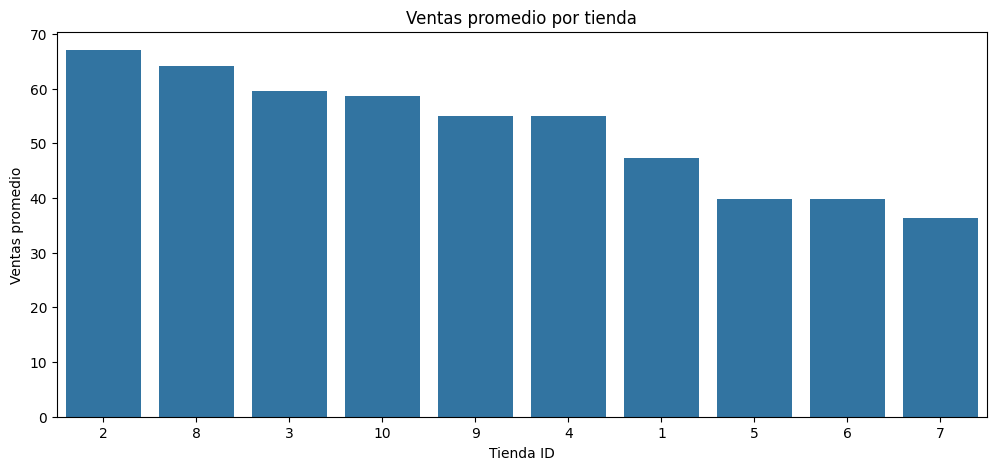

In [20]:
# Ventas promedio por tienda
store_avg = train.groupby('store')['sales'].mean().reset_index()

# Ordenamos el DataFrame por las ventas promedio de mayor a menor
store_avg_sorted = store_avg.sort_values(by='sales', ascending=False)

# Graficamos
plt.figure(figsize=(12, 5))
sns.barplot(x='store', y='sales', data=store_avg_sorted, order=store_avg_sorted['store'])
plt.title('Ventas promedio por tienda')
plt.xlabel('Tienda ID')
plt.ylabel('Ventas promedio')
plt.show()

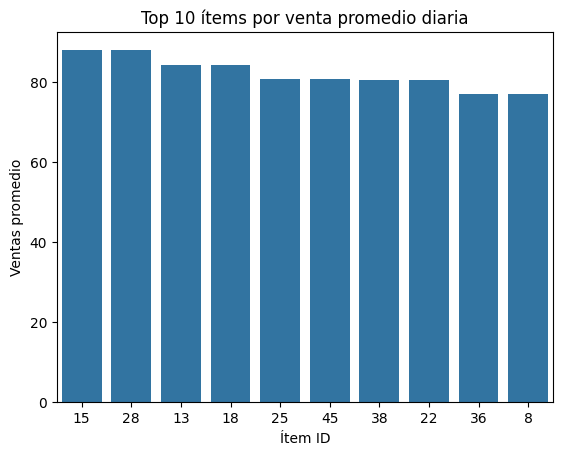

In [21]:
# Ventas promedio por √≠tem
top_items = train.groupby('item')['sales'].mean().sort_values(ascending=False).head(10)

plt.figure()
sns.barplot(
    x=top_items.index.astype(str), 
    y=top_items.values, 
    order=top_items.index.astype(str)
)
plt.title('Top 10 √≠tems por venta promedio diaria')
plt.xlabel('√çtem ID')
plt.ylabel('Ventas promedio')
plt.show()

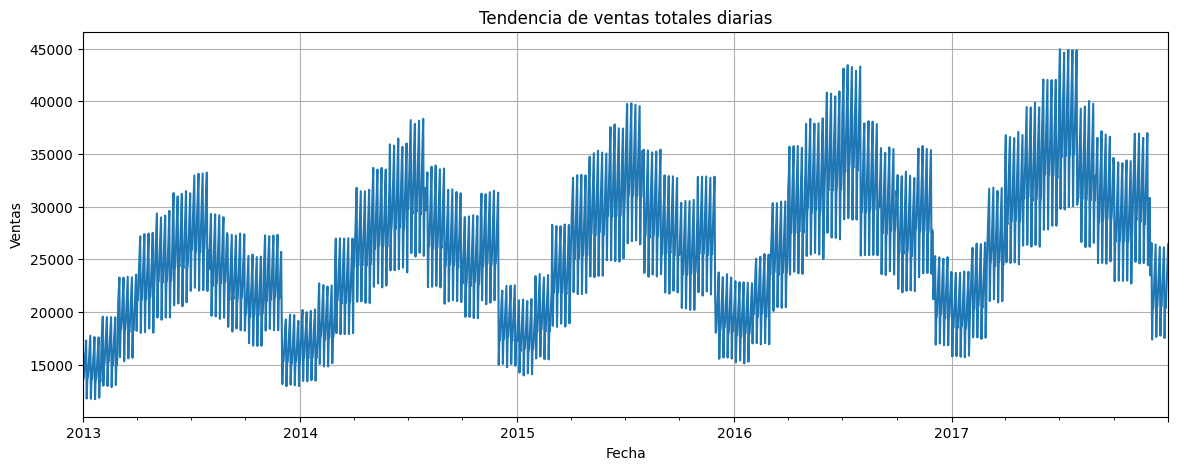

In [22]:
# Ventas diarias totales
daily_sales = train.groupby('date')['sales'].sum()

# Graficar
plt.figure(figsize=(14, 5))
daily_sales.plot()
plt.title('Tendencia de ventas totales diarias')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()


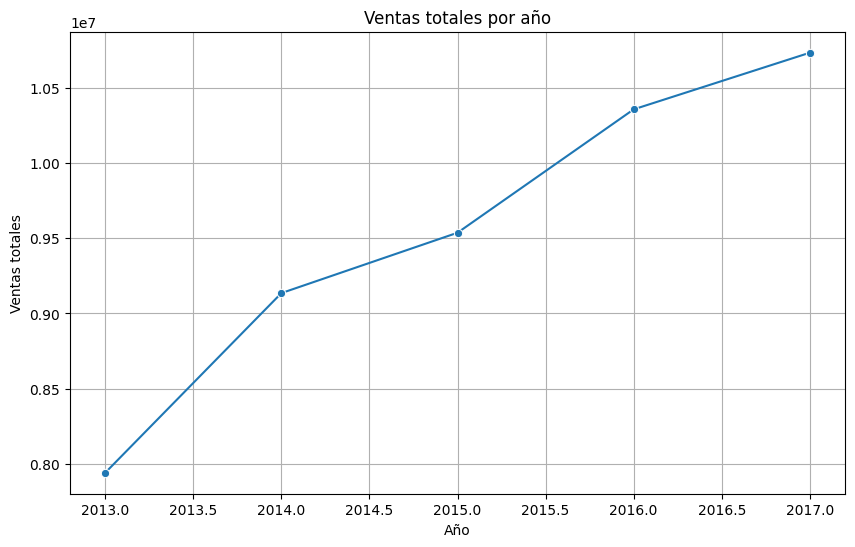

In [23]:
# Ventas por A√±o
sales_by_year = train.groupby('year')['sales'].sum()

# Graficamos
plt.figure(figsize=(10, 6))
sns.lineplot(x=sales_by_year.index.astype(int), y=sales_by_year.values, marker='o')
plt.title('Ventas totales por a√±o')
plt.xlabel('A√±o')
plt.ylabel('Ventas totales')
plt.grid(True)
plt.show()


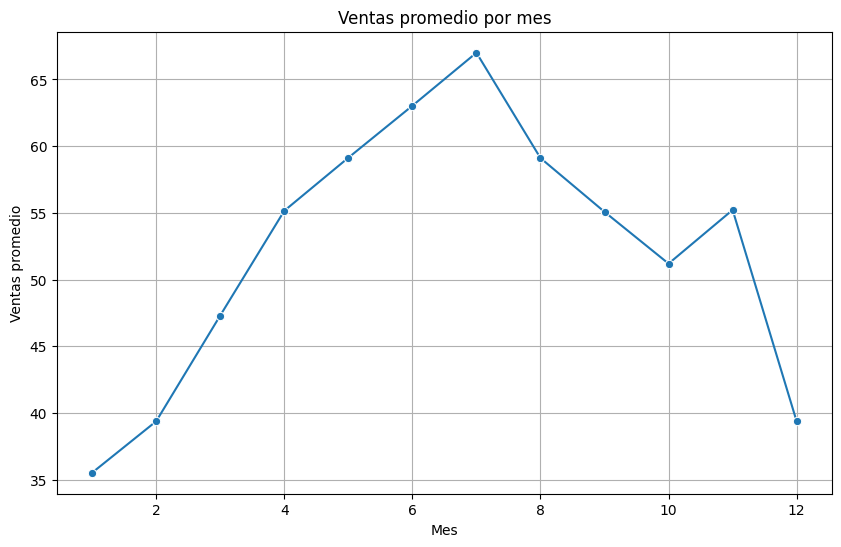

In [24]:
# Extraer mes
train['month'] = train['date'].dt.month

# Ventas promedio por mes
avg_sales_by_month = train.groupby('month')['sales'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sales_by_month.index, y=avg_sales_by_month.values, marker='o')
plt.title('Ventas promedio por mes')
plt.xlabel('Mes')
plt.ylabel('Ventas promedio')
plt.grid(True)
plt.show()


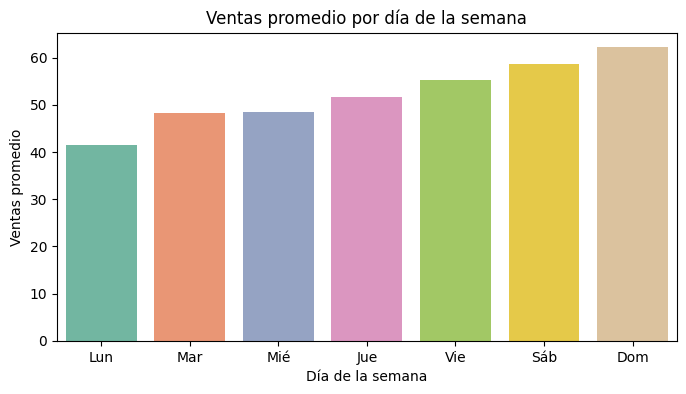

In [25]:
# Ventas por d√≠a de la semana
train['weekday'] = train['date'].dt.weekday

# Promedio de ventas por d√≠a
weekday_avg = train.groupby('weekday')['sales'].mean()

# Gr√°fico
plt.figure(figsize=(8, 4))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette='Set2')
plt.title('Ventas promedio por d√≠a de la semana')
plt.xlabel('D√≠a de la semana')
plt.ylabel('Ventas promedio')
plt.xticks(ticks=range(7), labels=['Lun', 'Mar', 'Mi√©', 'Jue', 'Vie', 'S√°b', 'Dom'])
plt.show()


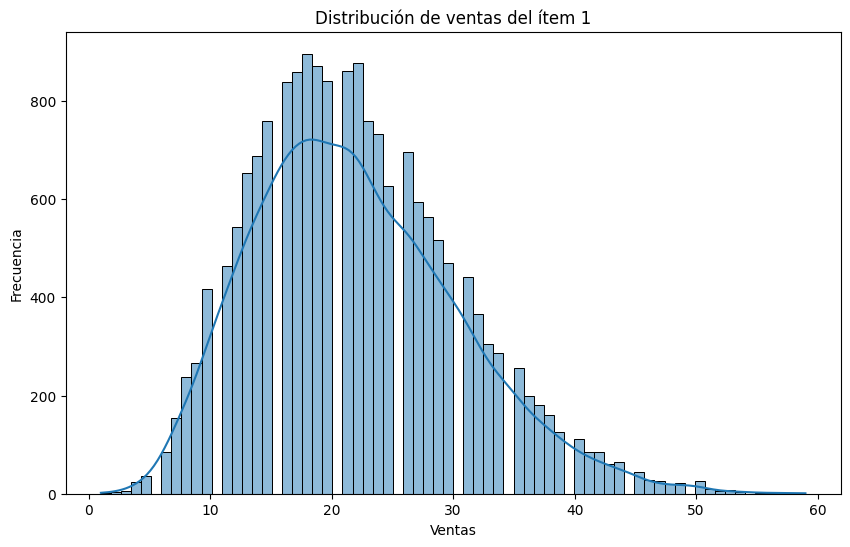

In [26]:
item_sales_dist = train[train['item'] == 1]['sales']  # Aqu√≠ puedes poner el item que desees
plt.figure(figsize=(10, 6))
sns.histplot(item_sales_dist, kde=True)
plt.title('Distribuci√≥n de ventas del √≠tem 1')
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')
plt.show()

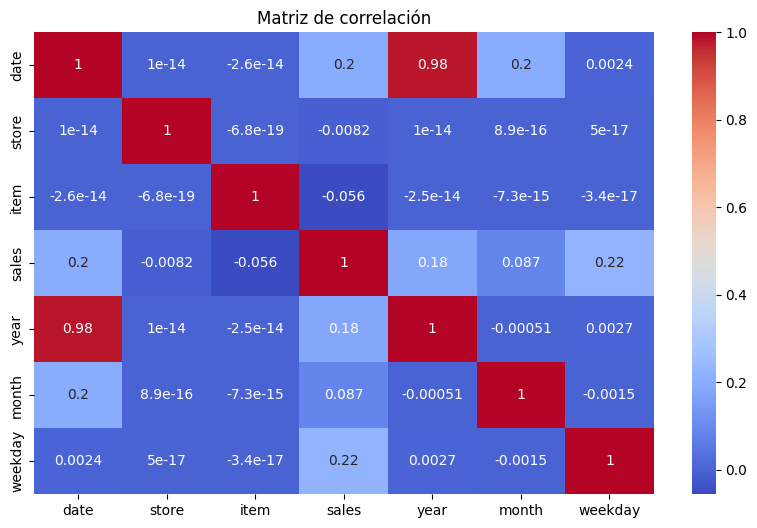

In [27]:
# Correlaci√≥n de Variables
corr = train.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlaci√≥n')
plt.show()

In [28]:
corr

date         store          item     sales          year  \
date     1.000000e+00  1.009177e-14 -2.584095e-14  0.195909  9.797959e-01   
store    1.009177e-14  1.000000e+00 -6.774332e-19 -0.008170  1.011427e-14   
item    -2.584095e-14 -6.774332e-19  1.000000e+00 -0.055998 -2.494470e-14   
sales    1.959089e-01 -8.170361e-03 -5.599807e-02  1.000000  1.823597e-01   
year     9.797959e-01  1.011427e-14 -2.494470e-14  0.182360  1.000000e+00   
month    1.988030e-01  8.890949e-16 -7.292755e-15  0.087414 -5.080291e-04   
weekday  2.373485e-03  4.985634e-17 -3.386967e-17  0.222608  2.711688e-03   

                month       weekday  
date     1.988030e-01  2.373485e-03  
store    8.890949e-16  4.985634e-17  
item    -7.292755e-15 -3.386967e-17  
sales    8.741417e-02  2.226076e-01  
year    -5.080291e-04  2.711688e-03  
month    1.000000e+00 -1.475063e-03  
weekday -1.475063e-03  1.000000e+00

## 5. Preparaci√≥n de los Datos para Prophet

In [29]:
# Convertir la columna 'date' a tipo datetime
train['date'] = pd.to_datetime(train['date'])

# Establecer la columna 'date' como √≠ndice del DataFrame
train.set_index('date', inplace=True)


In [30]:
# Agrupar las ventas por fecha (agregaci√≥n diaria)
train_daily = train.groupby('date')['sales'].sum()

# Visualizar las primeras filas para ver la estructura
train_daily.head()

date
2013-01-01    13696
2013-01-02    13678
2013-01-03    14488
2013-01-04    15677
2013-01-05    16237
Name: sales, dtype: int64

In [31]:
# Asegurar que la serie tenga frecuencia diaria continua
train_daily.index = pd.to_datetime(train_daily.index)
train_daily = train_daily.asfreq('D')

In [32]:
# Aplicar prueba de Dickey-Fuller aumentada (ADF) para evaluar la estacionariedad de la serie
# A pesar de que Prophet no requiere estacionariedad, es √∫til para conocer la naturaleza de la serie (puede servir para otros modelos)
adf_result = adfuller(train_daily)

# Mostrar los resultados
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -3.060244118701348
p-value: 0.029638649268843572
Critical Value 1%: -3.4339800605797155
Critical Value 5%: -2.8631434696839992
Critical Value 10%: -2.5676236347535166


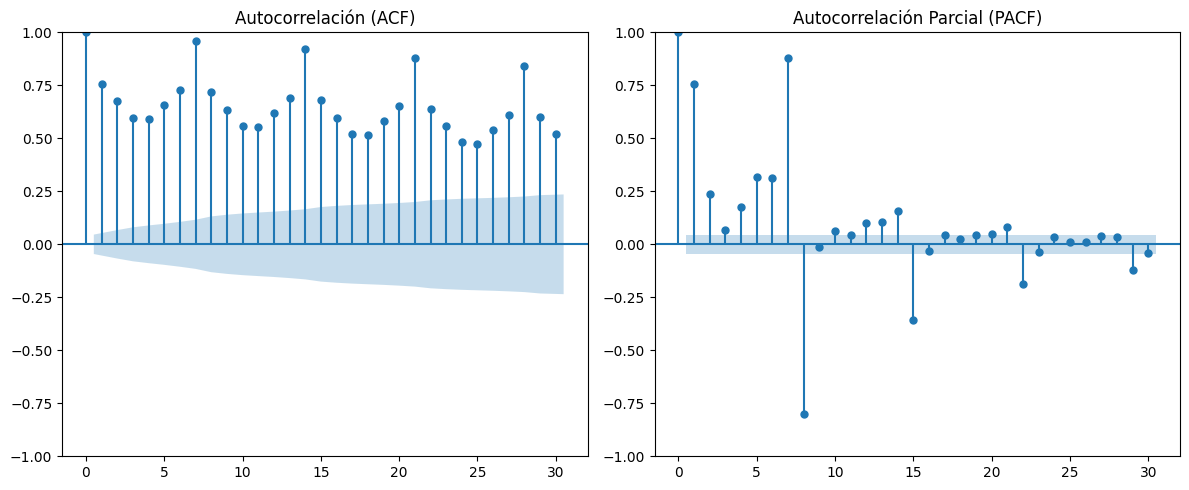

In [33]:
# Visualizaci√≥n de autocorrelaci√≥n y autocorrelaci√≥n parcial para detectar patrones estacionales
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(train_daily, lags=30, ax=plt.gca())
plt.title('Autocorrelaci√≥n (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(train_daily, lags=30, ax=plt.gca())
plt.title('Autocorrelaci√≥n Parcial (PACF)')

plt.tight_layout()
plt.show()

## 6.  Modelado con Prophet y Evaluaci√≥n del Modelo

In [34]:
# Prophet requiere que las columnas se llamen 'ds' para fechas y 'y' para valores
train_daily_df = train_daily.reset_index()
train_daily_df = train_daily_df.rename(columns={'date': 'ds', 'sales': 'y'})

16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing


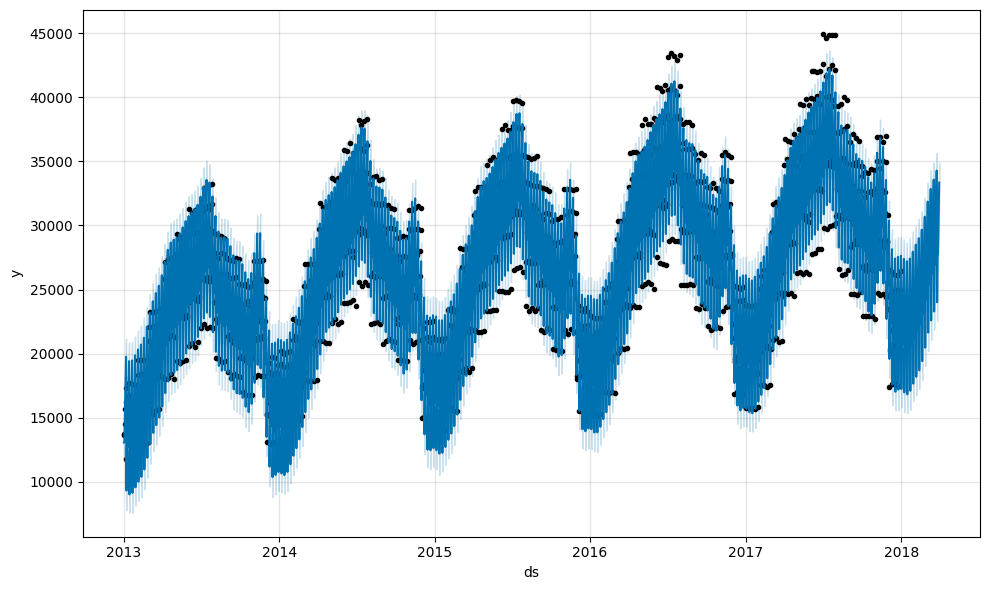

In [35]:
# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(train_daily_df)

# Crear fechas futuras para predicci√≥n (90 d√≠as adelante)
future = model.make_future_dataframe(periods=90)

# Hacer predicciones
forecast = model.predict(future)

# Visualizar la predicci√≥n completa con los datos hist√≥ricos
model.plot(forecast);

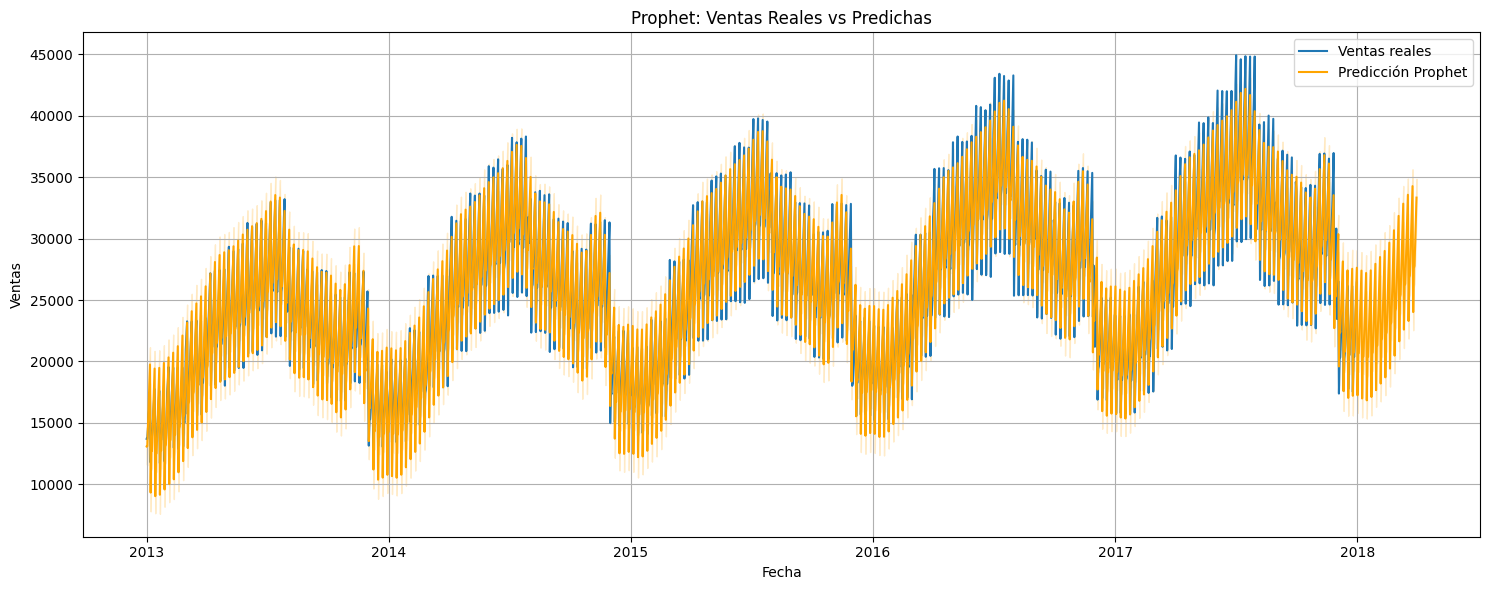

In [36]:
# Visualizar comparaci√≥n de ventas reales vs predicciones de Prophet
plt.figure(figsize=(15, 6))

# Datos reales
plt.plot(train_daily.index, train_daily.values, label='Ventas reales')

# Predicci√≥n de Prophet
plt.plot(forecast['ds'], forecast['yhat'], label='Predicci√≥n Prophet', color='orange')

# Banda de incertidumbre (opcional)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2)

plt.title('Prophet: Ventas Reales vs Predichas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

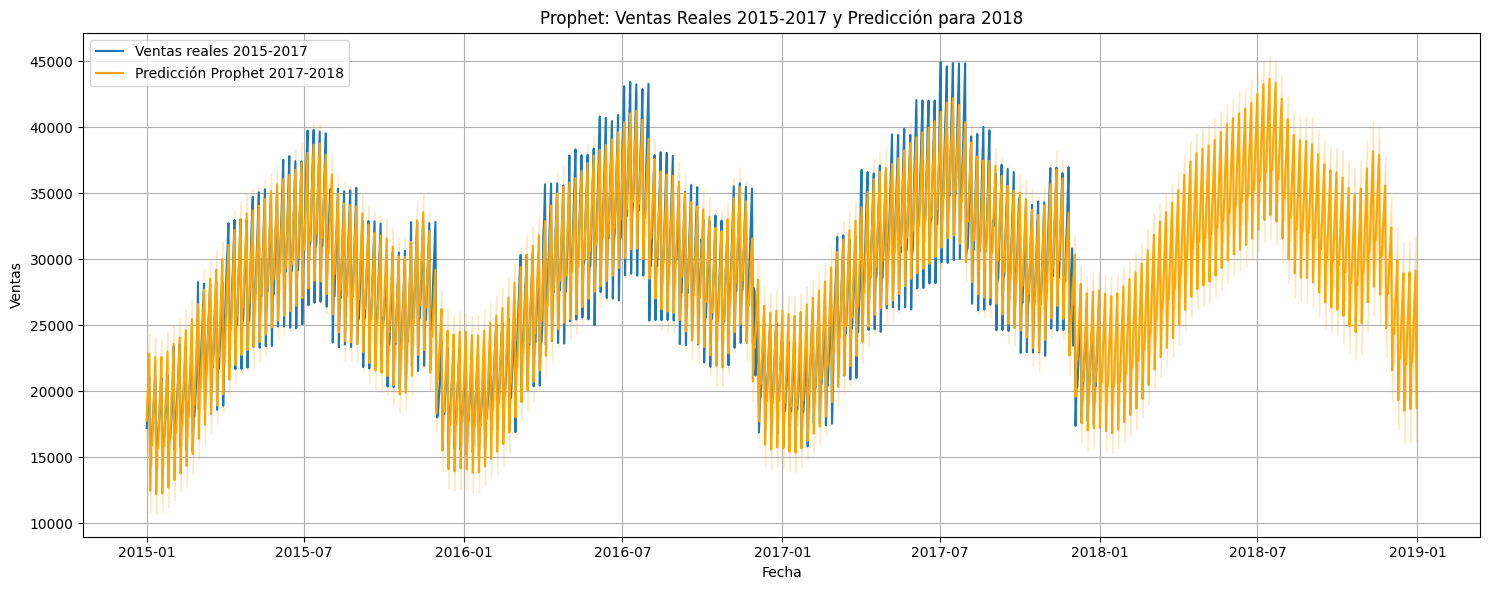

In [37]:
# Crear fechas futuras para predecir un a√±o adicional (365 d√≠as)
future = model.make_future_dataframe(periods=365)

# Hacer nuevas predicciones
forecast = model.predict(future)

# Definir rango de inter√©s
start_2017 = '2015-01-01'
end_2018 = '2018-12-31'

# Filtrar predicciones para ese rango
forecast_2017_2018 = forecast[(forecast['ds'] >= start_2017) & (forecast['ds'] <= end_2018)]

# Filtrar datos reales (hasta 2017 √∫nicamente)
real_2017 = train_daily[start_2017:end_2018]

# Visualizaci√≥n
plt.figure(figsize=(15, 6))
plt.plot(real_2017.index, real_2017.values, label='Ventas reales 2015-2017')
plt.plot(forecast_2017_2018['ds'], forecast_2017_2018['yhat'], label='Predicci√≥n Prophet 2017-2018', color='orange')

# Banda de incertidumbre
plt.fill_between(forecast_2017_2018['ds'],
                 forecast_2017_2018['yhat_lower'],
                 forecast_2017_2018['yhat_upper'],
                 color='orange', alpha=0.2)

plt.title('Prophet: Ventas Reales 2015-2017 y Predicci√≥n para 2018')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

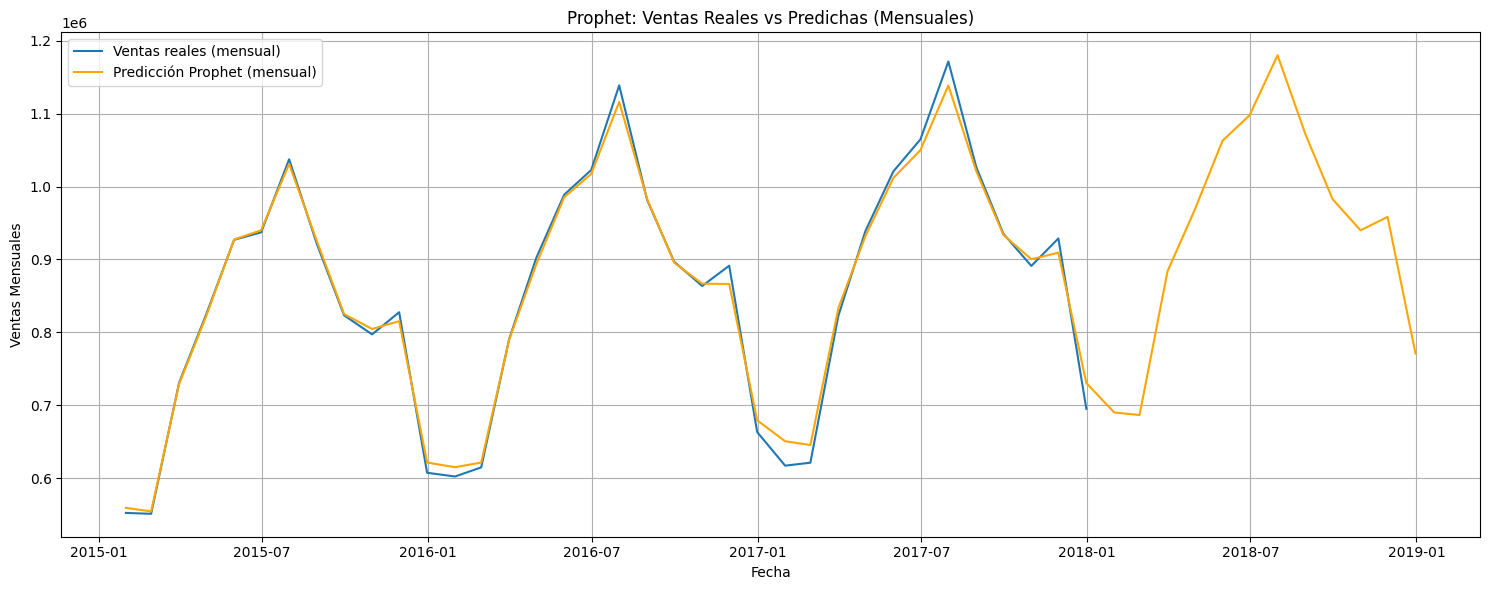

In [38]:
# Agregar ventas reales por mes (hasta 2017)
real_2017_monthly = train_daily[start_2017:end_2018].resample('M').sum()

# Agregar predicciones por mes
forecast_2017_2018_monthly = forecast_2017_2018.set_index('ds')['yhat'].resample('M').sum()

# Visualizaci√≥n mensual
plt.figure(figsize=(15, 6))
plt.plot(real_2017_monthly.index, real_2017_monthly.values, label='Ventas reales (mensual)')
plt.plot(forecast_2017_2018_monthly.index, forecast_2017_2018_monthly.values, label='Predicci√≥n Prophet (mensual)', color='orange')

plt.title('Prophet: Ventas Reales vs Predichas (Mensuales)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Mensuales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
forecast_eval = forecast.set_index('ds').loc[train_daily.index]
mae = mean_absolute_error(train_daily, forecast_eval['yhat'])
mse = mean_squared_error(train_daily, forecast_eval['yhat'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 890.65
RMSE: 1153.94


### Evaluaci√≥n del Modelo

En este paso, se calculan dos m√©tricas clave para evaluar el desempe√±o del modelo Prophet: **MAE (Error Absoluto Medio)** y **RMSE (Ra√≠z del Error Cuadr√°tico Medio)**.

- **MAE** (Mean Absolute Error): Mide el promedio de las diferencias absolutas entre las predicciones del modelo y los valores reales. Un MAE m√°s bajo indica que las predicciones del modelo est√°n m√°s cerca de los valores reales. En este caso, un MAE de `890.65` significa que, en promedio, el modelo cometi√≥ un error de aproximadamente `890.65` unidades en las ventas diarias.

- **RMSE** (Root Mean Squared Error): Mide la ra√≠z cuadrada del promedio de los errores al cuadrar las diferencias entre las predicciones y los valores reales. Este valor penaliza los errores m√°s grandes, lo que significa que es m√°s sensible a los valores at√≠picos. Un RMSE de `1153.94` sugiere que, aunque el modelo es bastante preciso en general, hay algunos errores que son m√°s grandes de lo esperado. Sin embargo, en relaci√≥n con la magnitud de las ventas diarias, el error es moderado.

Aunque estos resultados indican que el modelo tiene un buen desempe√±o, es importante seguir monitorizando su rendimiento y realizar ajustes si es necesario, especialmente en presencia de valores at√≠picos o patrones estacionales que el modelo podr√≠a no estar capturando completamente.

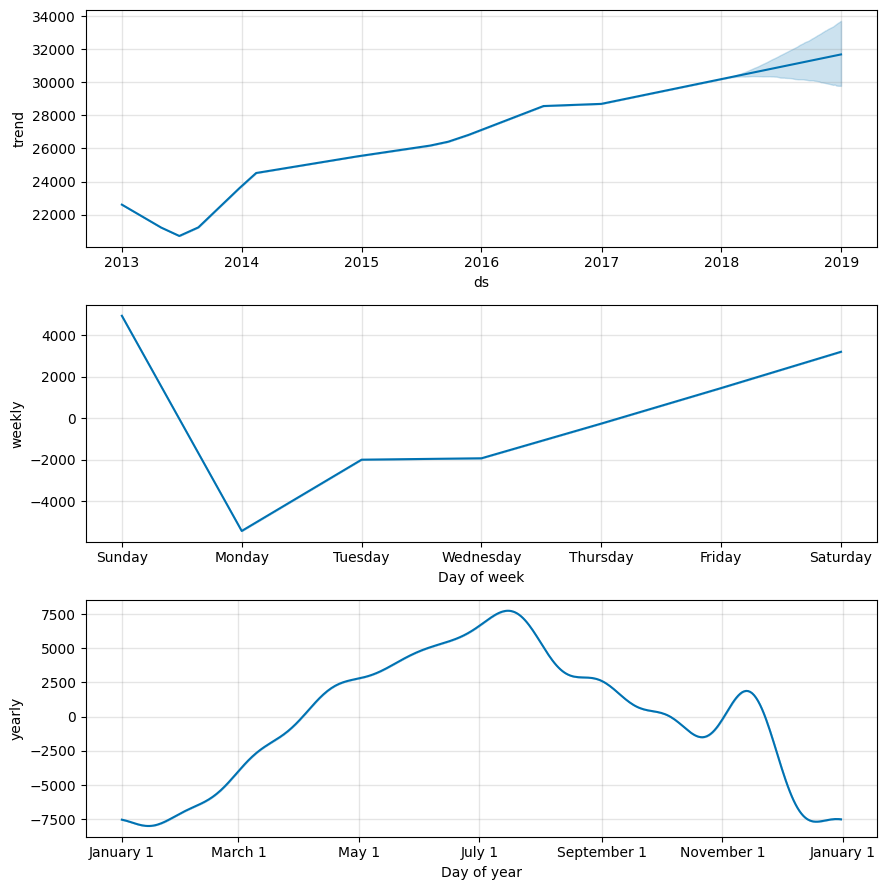

In [40]:
model.plot_components(forecast);

### An√°lisis de Componentes del Modelo Prophet

Al utilizar la funci√≥n `model.plot_components(forecast)`, hemos desglosado las principales contribuciones que afectan a las predicciones del modelo Prophet. Esta visualizaci√≥n permite analizar los siguientes componentes:

- **Tendencia**: Muestra la evoluci√≥n general de las ventas a lo largo del tiempo. En esta secci√≥n, se puede observar una tendencia creciente en las ventas, lo cual es clave para entender el comportamiento a largo plazo del negocio.
  
- **Estacionalidad**: Representa las fluctuaciones recurrentes en las ventas, como patrones diarios, semanales o anuales. Por ejemplo, en el contexto del retail, las ventas podr√≠an aumentar los fines de semana o durante fechas especiales. La gr√°fica de estacionalidad ayuda a identificar estos patrones y permite validar si el modelo est√° capturando correctamente la variabilidad en las ventas debido a la estacionalidad.

En resumen, esta visualizaci√≥n ofrece una interpretaci√≥n detallada de c√≥mo las diferentes componentes (tendencia, estacionalidad) afectan las predicciones del modelo. Permite realizar ajustes si es necesario, especialmente si observamos patrones de comportamiento no capturados correctamente por el modelo, lo cual puede ser √∫til para mejorar la precisi√≥n de las predicciones en futuros an√°lisis.


In [41]:
forecast.to_csv('forecast_prophet.csv', index=False)

### An√°lisis por Tienda y Producto

In [42]:
# Crear un DataFrame vac√≠o para almacenar predicciones
all_forecasts = []

In [43]:
# Iterar por cada combinaci√≥n de tienda y producto
stores = train['store'].unique()
items = train['item'].unique()

In [44]:
for store in tqdm(stores, desc='Stores'):
    for item in items:
        # Filtrar datos para la combinaci√≥n tienda-producto
        df = train[(train['store'] == store) & (train['item'] == item)]

        # Agrupar por fecha y sumar ventas
        df_grouped = df.groupby('date')['sales'].sum().reset_index()

        # Renombrar columnas para Prophet
        df_grouped = df_grouped.rename(columns={'date': 'ds', 'sales': 'y'})

        # Evitar series vac√≠as o demasiado cortas
        if len(df_grouped) < 100:
            continue

        # Crear y entrenar el modelo
        model = Prophet()
        model.fit(df_grouped)

        # Generar fechas futuras (3 meses = 90 d√≠as)
        future = model.make_future_dataframe(periods=90)

        # Predecir
        forecast = model.predict(future)

        # Seleccionar columnas necesarias y agregar store/item
        forecast_subset = forecast[['ds', 'yhat']].copy()
        forecast_subset['store'] = store
        forecast_subset['item'] = item

        # Guardar predicciones
        all_forecasts.append(forecast_subset)

Stores:   0%|                                                                                   | 0/10 [00:00<?, ?it/s]16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:27:00 - cmdstanpy - INFO - Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Cha

In [45]:
total_forecast = pd.concat(all_forecasts)

In [46]:
total_forecast = total_forecast[['ds', 'store', 'item', 'yhat']]

In [47]:
print(total_forecast.head())

          ds  store  item       yhat
0 2013-01-01      1     1   8.646726
1 2013-01-02      1     1   9.306336
2 2013-01-03      1     1   9.983400
3 2013-01-04      1     1  11.548046
4 2013-01-05      1     1  13.491892


In [48]:
# Combinar todos los DataFrames de predicci√≥n en uno solo
all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)

# Asegurarse de que 'train' tiene el √≠ndice como columna
train_reset = train.reset_index()

# Renombrar columna para que coincida con Prophet
train_reset = train_reset.rename(columns={'date': 'ds', 'sales': 'actual'})

# Unir predicciones con datos reales
real_vs_pred = pd.merge(all_forecasts_df, train_reset, on=['ds', 'store', 'item'], how='left')

# Calcular errores absolutos y porcentuales
real_vs_pred['abs_error'] = abs(real_vs_pred['actual'] - real_vs_pred['yhat'])
real_vs_pred['pct_error'] = abs(real_vs_pred['actual'] - real_vs_pred['yhat']) / real_vs_pred['actual']

# Reordenar columnas mostrar valores y predicci√≥n al final
cols = [col for col in real_vs_pred.columns if col not in ['actual', 'yhat', 'abs_error', 'pct_error']]
cols += ['actual', 'yhat', 'abs_error', 'pct_error']
real_vs_pred = real_vs_pred[cols]

# Vemos el resultado
real_vs_pred.head()


ds  store  item    year  month  weekday  actual       yhat  \
0 2013-01-01      1     1  2013.0    1.0      1.0    13.0   8.646726   
1 2013-01-02      1     1  2013.0    1.0      2.0    11.0   9.306336   
2 2013-01-03      1     1  2013.0    1.0      3.0    14.0   9.983400   
3 2013-01-04      1     1  2013.0    1.0      4.0    13.0  11.548046   
4 2013-01-05      1     1  2013.0    1.0      5.0    10.0  13.491892   

   abs_error  pct_error  
0   4.353274   0.334867  
1   1.693664   0.153969  
2   4.016600   0.286900  
3   1.451954   0.111689  
4   3.491892   0.349189

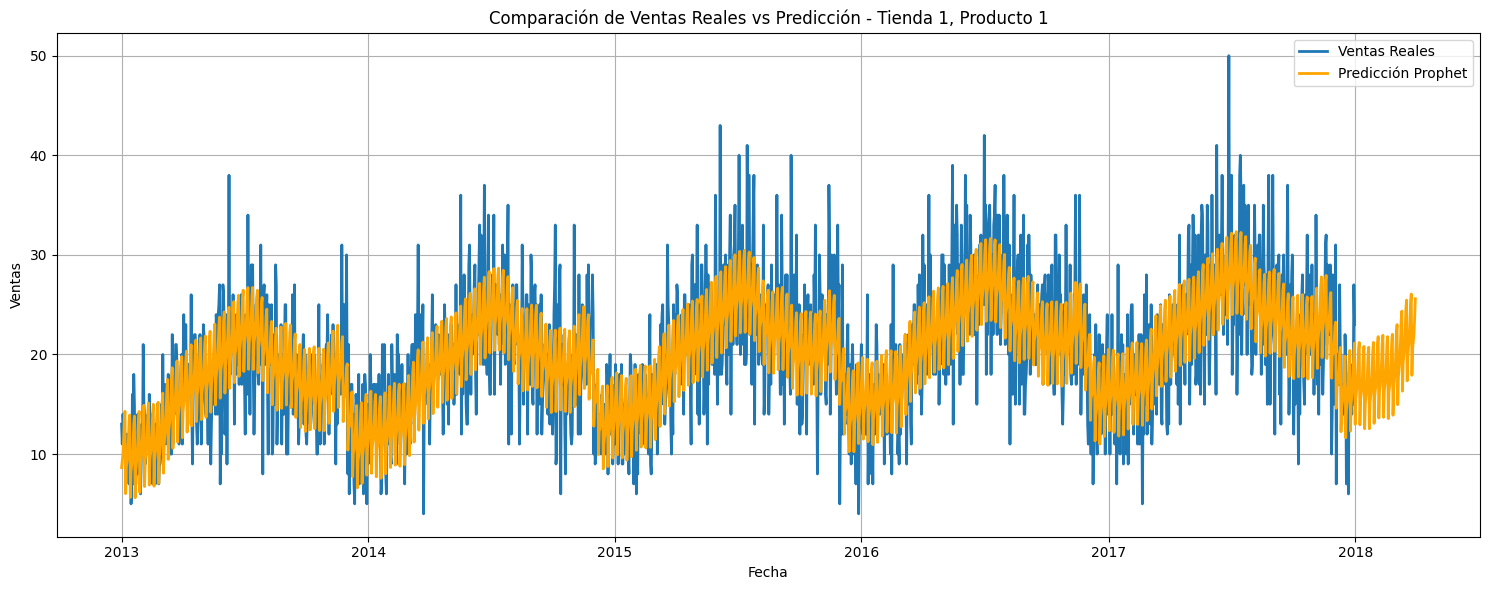

In [49]:
# Comparativo predicciones vs real con tienda y producto
# Elegir tienda y producto
store_id = 1
item_id = 1

# Filtrar los datos para esa combinaci√≥n
df_plot = real_vs_pred[(real_vs_pred['store'] == store_id) & (real_vs_pred['item'] == item_id)].copy()

# Ordenar por fecha por si acaso
df_plot = df_plot.sort_values('ds')

# Crear gr√°fico
plt.figure(figsize=(15, 6))
plt.plot(df_plot['ds'], df_plot['actual'], label='Ventas Reales', linewidth=2)
plt.plot(df_plot['ds'], df_plot['yhat'], label='Predicci√≥n Prophet', linewidth=2, color='orange')

plt.title(f'Comparaci√≥n de Ventas Reales vs Predicci√≥n - Tienda {store_id}, Producto {item_id}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Guardar el DataFrame final en un archivo CSV
real_vs_pred.to_csv('ventas_predicciones_vs_reales.csv', index=False, encoding='utf-8')

## 7. Conclusiones

Este an√°lisis de pron√≥stico de ventas utilizando el modelo Prophet ha permitido obtener valiosos insights sobre el comportamiento de ventas en distintas tiendas y productos. A lo largo del proceso, se abordaron cuestiones clave que impactan directamente en la toma de decisiones comerciales, como la estacionalidad y la forma en que las tiendas deben ser modeladas.

### Metodolog√≠a y Herramientas Utilizadas

- **Lenguaje de programaci√≥n:** Python.
- **Librer√≠as utilizadas:** pandas, matplotlib, seaborn, numpy, Prophet.
- **T√©cnicas aplicadas:** Limpieza y transformaci√≥n de datos, modelado de series temporales, an√°lisis de tendencias y patrones, visualizaci√≥n de componentes.
- **Tipo de gr√°ficos:** Gr√°ficos de l√≠neas, barras y componentes estacionales, utilizados para facilitar la interpretaci√≥n visual de los resultados.

### Principales Hallazgos

- **Estacionalidad:** Se identificaron patrones estacionales marcados en los datos, como el aumento de ventas en ciertas estaciones del a√±o. Esto se model√≥ efectivamente con Prophet utilizando los componentes estacionales autom√°ticos.
- **Diferencias entre tiendas y productos:** Cada tienda y producto tiene su propio comportamiento, lo que hace que el modelado por separado sea m√°s preciso en comparaci√≥n con el enfoque agregado.
- **Optimizaci√≥n de recursos:** Agrupar tiendas o productos en un solo modelo puede reducir el costo computacional, pero a veces sacrifica la capacidad de capturar patrones espec√≠ficos.

### Impacto del An√°lisis

Gracias a este an√°lisis, se respondieron preguntas clave del negocio relacionadas con:

- **Segmentaci√≥n:** Identificaci√≥n de tendencias estacionales y comportamientos espec√≠ficos por tienda y producto.
- **Temporadas de alta y baja venta:** Posibilidad de ajustar inventarios y estrategias de ventas seg√∫n las estaciones del a√±o y los d√≠as de la semana.
- **Optimizaci√≥n de promociones y stock:** Ajustes espec√≠ficos para cada tienda y producto basados en su comportamiento hist√≥rico.

Este an√°lisis puede ser la base para modelos m√°s avanzados de predicci√≥n o recomendaciones personalizadas, y puede aportar valor directo en la toma de decisiones estrat√©gicas para la gesti√≥n de ventas y el marketing.

### ¬øCu√°l es la mejor manera de tratar la estacionalidad?

En series temporales, la **estacionalidad** se refiere a patrones o ciclos recurrentes en los datos (por ejemplo, semanales o anuales). Prophet maneja la estacionalidad de manera muy efectiva y autom√°tica gracias a su soporte integrado para:

- **Estacionalidad anual**
- **Estacionalidad semanal**

Para tratar la estacionalidad de la mejor manera posible, se puede: 

**Usar los componentes estacionales integrados de Prophet:**  
Prophet modela autom√°ticamente la estacionalidad semanal y anual. Estos componentes se pueden visualizar con `model.plot_components(forecast)` para entender su impacto a lo largo del tiempo.

### üè¨ ¬øDeber√≠an modelarse las tiendas por separado o pueden agruparse?

Una pregunta com√∫n en series temporales multivariadas es si conviene **modelar cada tienda individualmente** o si es posible **agruparlas (pooling)** en un solo modelo para ahorrar recursos computacionales o mejorar la generalizaci√≥n.

#### ‚úÖ Modelar por separado
Modelar cada combinaci√≥n de `store` e `item` de manera independiente tiene ventajas clave:
- Captura mejor la **estacionalidad y tendencias espec√≠ficas** de cada tienda o producto.
- Permite ajustes personalizados y mejora la precisi√≥n.
- Evita promediar comportamientos distintos que pueden anular patrones importantes.

#### üîÅ Agrupamiento (pooling)
Agrupar m√∫ltiples tiendas o productos en un solo modelo puede:
- Reducir el costo computacional.
- Ayudar cuando hay **pocos datos por serie individual** (por ejemplo, tiendas nuevas).
- Ser √∫til para detectar **tendencias generales del negocio**, pero puede perder detalle.


### ‚öôÔ∏è ¬øQu√© se hizo en este proyecto?

En este proyecto se probaron **ambas estrategias**:

1. ‚úÖ **Modelo agregado:**  
   Inicialmente se entren√≥ un modelo Prophet sobre los datos agregados por d√≠a (`train_daily`) para evaluar tendencias generales y validar el enfoque.

2. üß© **Modelos por tienda y producto:**  
   Luego se opt√≥ por modelar cada combinaci√≥n `store`-`item` por separado, ya que esto permiti√≥ capturar patrones √∫nicos de estacionalidad y ventas. Prophet fue entrenado en bucle para cada serie individual, generando predicciones espec√≠ficas y mejorando el desempe√±o global.

Esta segunda estrategia ofreci√≥ una mayor capacidad para personalizar los modelos seg√∫n las caracter√≠sticas particulares de cada tienda y art√≠culo, y result√≥ ser m√°s adecuada para el objetivo del proyecto: **predecir ventas espec√≠ficas de cada producto en cada tienda con mayor precisi√≥n**.

## 8. Anexos y Recursos

### Fuente de Datos
- **Dataset utilizado:** [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only)  

### Herramientas Utilizadas
- **Python** para an√°lisis de datos y visualizaci√≥n.
- **Librer√≠as principales:**
  - `pandas`: para manipulaci√≥n y an√°lisis de datos tabulares.
  - `matplotlib` y `seaborn`: para visualizaci√≥n de datos.
  - `Prophet`: para modelado de series temporales y predicci√≥n de ventas.
  - `numpy`: para c√°lculos num√©ricos y agrupaciones.

### Notas Complementarias
- El dataset fue procesado para ajustarse al modelo de Prophet, transformando las columnas necesarias (fecha, ventas, tienda y art√≠culo) para ajustarlas a la estructura que Prophet requiere (`ds` para fecha y `y` para las ventas).
- Se realiz√≥ un an√°lisis exploratorio para identificar patrones de estacionalidad y tendencias en las ventas a lo largo del tiempo.
- Se utilizaron diferentes enfoques para modelar las ventas, tanto a nivel agregado como a nivel individual por tienda y art√≠culo, para evaluar cu√°l estrategia proporcionaba las predicciones m√°s precisas.


### Proyectos Relacionados
- En paralelo a este an√°lisis, se desarroll√≥ un **dashboard interactivo en Power BI** que visualiza tanto los datos hist√≥ricos como las predicciones generadas con Prophet. Este dashboard permitir√° a los usuarios explorar din√°micamente las predicciones de ventas por tienda y art√≠culo, ofreciendo un enfoque m√°s visual e interactivo para la toma de decisiones.


### Recomendaciones T√©cnicas Futuras
- **Optimizaci√≥n de modelos predictivos:** Mejorar la precisi√≥n de las predicciones mediante t√©cnicas adicionales como la integraci√≥n de datos externos (por ejemplo, datos sobre promociones o condiciones econ√≥micas).
- **Modelos adicionales:** Ampliar el an√°lisis para incluir otras t√©cnicas de predicci√≥n, como redes neuronales o modelos de machine learning avanzados, para comparar su desempe√±o con Prophet.
- **An√°lisis de segmentaci√≥n:** Implementar segmentaciones adicionales de clientes y productos, utilizando t√©cnicas como clustering, para obtener insights m√°s espec√≠ficos y personalizados sobre los patrones de compra.
